In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append("../input/timmmaster/")
from timm import create_model
import pandas as pd
import numpy as np

In [3]:
import fastai
fastai.__version__

'2.5.3'

In [4]:
import torch
torch.__version__

'1.9.1'

In [5]:
from fastai.vision.all import *

In [6]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8                      #was 32

In [7]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

In [8]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


In [12]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [13]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [18]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [19]:
def get_data(fold):
    train_df_f = pd.read_csv(f'../input/data-split-pawpularity/skf_split_train_5cv_fold{fold}.csv')
    train_df_f['is_valid'] = False
    valid_df_f = pd.read_csv(f'../input/data-split-pawpularity/skf_split_val_5cv_fold{fold}.csv')
    valid_df_f['is_valid'] = True
    
    train_df_f = train_df_f.append(valid_df_f)
    train_df_f['Id'] = train_df_f['img_path'].apply(lambda x: x.split('.')[-2].split('/')[-1])
    train_df_f['img_path'] = train_df_f['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='img_path', #filename/path is in the second column of the DataFrame
                               label_col='Pawpularity', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(384), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    return dls


In [20]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [21]:
!ls

__notebook__.ipynb


In [22]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
#     model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)
    model = create_model('swin_base_patch4_window12_384', pretrained=True, num_classes=data.c)
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(func=petfinder_rmse)).to_fp16()
    
    return learn

In [23]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [24]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [25]:
import gc

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window12_384_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window12_384_22kto1k.pth


SuggestedLRs(valley=4.828246164834127e-05)

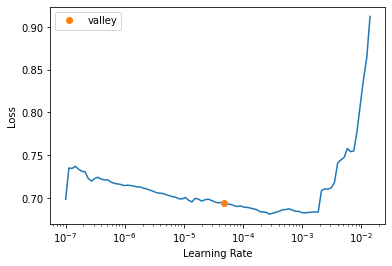

In [26]:
a = get_learner(fold_num=0)
a.lr_find(end_lr=3e-2)             #was-2

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658818,0.658248,19.916420,12:54
1,0.650348,0.645130,18.285734,12:54
2,0.643148,0.642044,17.884480,12:55
3,0.636048,0.641611,17.811274,12:54
4,0.635696,0.643308,18.009605,12:55
5,0.634298,0.640937,17.719769,12:55
6,0.636522,0.640785,17.694738,12:54
7,0.625179,0.641201,17.742331,12:55
8,0.631048,0.641523,17.775259,12:55


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.916419982910156.
Better model found at epoch 1 with petfinder_rmse value: 18.285734176635742.
Better model found at epoch 2 with petfinder_rmse value: 17.884479522705078.
Better model found at epoch 3 with petfinder_rmse value: 17.8112735748291.
Better model found at epoch 5 with petfinder_rmse value: 17.719768524169922.
Better model found at epoch 6 with petfinder_rmse value: 17.694738388061523.
No improvement since epoch 6: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658059,0.658197,19.836851,12:55
1,0.641944,0.646659,18.383554,12:56
2,0.641072,0.643489,17.985027,12:55
3,0.632735,0.643363,17.961002,12:56
4,0.634911,0.644304,18.080620,12:55
5,0.635500,0.644182,18.065815,12:54


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.836851119995117.
Better model found at epoch 1 with petfinder_rmse value: 18.383554458618164.
Better model found at epoch 2 with petfinder_rmse value: 17.985027313232422.
Better model found at epoch 3 with petfinder_rmse value: 17.961002349853516.
No improvement since epoch 3: early stopping


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653839,0.657435,19.827852,12:55
1,0.643271,0.648331,18.659090,12:55
2,0.644579,0.644411,18.191483,12:55
3,0.639549,0.640568,17.677271,12:55
4,0.633930,0.640369,17.624279,12:56
5,0.631554,0.641360,17.735014,12:57
6,0.630598,0.639844,17.560684,12:55
7,0.627265,0.639862,17.552462,12:55
8,0.622346,0.640129,17.584898,12:55
9,0.628144,0.640273,17.602091,12:56


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.827852249145508.
Better model found at epoch 1 with petfinder_rmse value: 18.659090042114258.
Better model found at epoch 2 with petfinder_rmse value: 18.191482543945312.
Better model found at epoch 3 with petfinder_rmse value: 17.677270889282227.
Better model found at epoch 4 with petfinder_rmse value: 17.624279022216797.
Better model found at epoch 6 with petfinder_rmse value: 17.560684204101562.
Better model found at epoch 7 with petfinder_rmse value: 17.552461624145508.
No improvement since epoch 7: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.654551,0.657691,19.799442,12:56
1,0.646793,0.642798,17.899693,12:55
2,0.648923,0.640147,17.546637,12:57
3,0.637874,0.639947,17.526398,12:56
4,0.634558,0.639076,17.400976,12:56
5,0.631152,0.638287,17.267490,12:56
6,0.627275,0.638225,17.256161,12:58
7,0.630313,0.638585,17.322468,12:57
8,0.631724,0.638461,17.292969,12:59


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.799442291259766.
Better model found at epoch 1 with petfinder_rmse value: 17.89969253540039.
Better model found at epoch 2 with petfinder_rmse value: 17.5466365814209.
Better model found at epoch 3 with petfinder_rmse value: 17.526397705078125.
Better model found at epoch 4 with petfinder_rmse value: 17.400976181030273.
Better model found at epoch 5 with petfinder_rmse value: 17.26749038696289.
Better model found at epoch 6 with petfinder_rmse value: 17.256160736083984.
No improvement since epoch 6: early stopping


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.662681,0.658340,19.900881,12:57
1,0.648018,0.646682,18.429850,12:58
2,0.644584,0.641837,17.815586,12:57
3,0.637648,0.639345,17.485249,12:57
4,0.632696,0.639973,17.550697,12:56
5,0.635538,0.639678,17.506968,12:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 19.900880813598633.
Better model found at epoch 1 with petfinder_rmse value: 18.42984962463379.
Better model found at epoch 2 with petfinder_rmse value: 17.81558609008789.
Better model found at epoch 3 with petfinder_rmse value: 17.485248565673828.
No improvement since epoch 3: early stopping


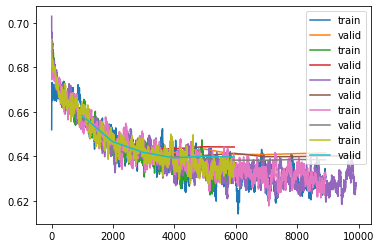

In [28]:
all_preds = []

for i in range(5):

    print(f'Fold {i} results')
#     i = 1
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(10, 3e-6, cbs=[SaveModelCallback('petfinder_rmse', comp=np.less), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    learn = learn.to_fp32()
    
    learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(384), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [30]:
!ls ..

input  lib  src  working


In [31]:
all_preds

[tensor([[0.4695],
         [0.4766],
         [0.4832],
         [0.4851],
         [0.4788],
         [0.4794],
         [0.4775],
         [0.4786]]),
 tensor([[0.5550],
         [0.5619],
         [0.5527],
         [0.5541],
         [0.5642],
         [0.5506],
         [0.5692],
         [0.5535]]),
 tensor([[0.5901],
         [0.5956],
         [0.5853],
         [0.5866],
         [0.5974],
         [0.5816],
         [0.6032],
         [0.5854]]),
 tensor([[0.5809],
         [0.5870],
         [0.5722],
         [0.5820],
         [0.5832],
         [0.5723],
         [0.5901],
         [0.5762]]),
 tensor([[0.5404],
         [0.5459],
         [0.5354],
         [0.5407],
         [0.5445],
         [0.5333],
         [0.5543],
         [0.5358]])]

In [32]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [33]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,54.719986
1,43a2262d7738e3d420d453815151079e,55.340965
2,4e429cead1848a298432a0acad014c9d,54.576744
3,80bc3ccafcc51b66303c2c263aa38486,54.971092
4,8f49844c382931444e68dffbe20228f4,55.362003
